In [1]:
import numpy as np
import importlib.util
import matplotlib.pyplot as plt
import pickle

import threading
# import torch

# if torch.cuda.is_available():  
#   dev = "cuda:1" 
# else:  
#   dev = "cpu"  

# device = torch.device(dev)

from simpleinfotheory import entropy

# from dp_laplace_mechanism import laplace_mechanism
 
# specify the module that needs to be
# imported relative to the path of the
# module
latent_load_module = importlib.util.spec_from_file_location("load_latent","/home/sjay9734/diff_encoder/face_privacy/face-privacy-diffae/utils/load_latent.py")
 
# creates a new module based on spec
latent_load = importlib.util.module_from_spec(latent_load_module)
 
# executes the module in its own namespace
# when a module is imported or reloaded.
latent_load_module.loader.exec_module(latent_load)

X_train, y_train, X_test, y_test = latent_load.pre_process_celebA(TRAINING_AMOUNT = 0.9)

In [2]:
!nvidia-smi

Fri Sep 22 21:18:44 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080        Off | 00000000:01:00.0 Off |                  N/A |
| 30%   38C    P2              87W / 320W |    564MiB / 10240MiB |     15%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
NO_BINS = 100
CLIP_ = 0

limit_ = []
for i in range(np.shape(X_train)[1]):
    min_val = np.min(X_train[:,i])
    max_val = np.max(X_train[:,i])

    limit_.append([min_val + CLIP_*abs(min_val), max_val - CLIP_*abs(max_val)])

def cal_hist(data, X_train, histograms, NO_BINS=NO_BINS, limit_=limit_, start_index = 0):
    no_axes = np.shape(data)[1]
    no_axes_x_train = np.shape(X_train)[1]

    for i in range(no_axes):
        for j in range(no_axes_x_train):
            H, _, _ = np.histogram2d(data[:, i], X_train[:, j], bins=NO_BINS, range=[[limit_[i + start_index][0], limit_[i + start_index][1]], [limit_[j][0], limit_[j][1]]], density=False)
            histograms.append(H)



In [5]:
NO_THREADS = 8 # make it power of 2

no_axes = np.shape(X_train)[1]
no_samples = np.shape(X_train)[0]
threads = []

value_range = []
i = 0
results = [[]]
for i in range(NO_THREADS-1):
    results.append([])
    value_range.append([(no_axes//NO_THREADS)*i, (no_axes//NO_THREADS)*(i+1)])
value_range.append([(no_axes//NO_THREADS)*(i+1), 512])

print(value_range)

# for i in range(NO_THREADS):
#     x = threading.Thread(target=cal_hist, args=(X_train[:,value_range[i][0]:value_range[i][1]], X_train, results[i], NO_BINS, limit_, value_range[i][0]))
#     threads.append(x)
#     x.start()

# for index, thread in enumerate(threads):
#     thread.join()

# print(len(results))

[[0, 64], [64, 128], [128, 192], [192, 256], [256, 320], [320, 384], [384, 448], [448, 512]]


In [6]:
# with open('hist_512.npy', 'wb') as f:
#     np.save(f, np.array(results, dtype = np.float32))

results = np.load('hist_512.npy')

In [40]:
# results = np.load('hist_512.npy')

In [2]:
laplace_mechanism_loader = importlib.util.spec_from_file_location("load_latent","/home/sjay9734/diff_encoder/face_privacy/face-privacy-diffae/privacy_mechanisms/dp_laplace_mechanism.py")
 
# creates a new module based on spec
laplace = importlib.util.module_from_spec(laplace_mechanism_loader)
 
# executes the module in its own namespace
# when a module is imported or reloaded.
laplace_mechanism_loader.loader.exec_module(laplace)

In [3]:
correlated_axes_list = [] # each sub list contain correlae]ted axis indexes

for i in results:
    index = 0
    print(len(i)%512)
    for j in range(len(i)//512):
        inner_correlated_list = []
        for k in range(512):
            # j /= no_samples # normalizing
            normalized_j = i[index]/no_samples
            # print(np.sum(normalized_j))
            dist_x = np.sum(normalized_j, axis = 0)
            dist_y = np.sum(normalized_j, axis = 1)
            flattern_dist = normalized_j.flatten()
            entropy_x = entropy(dist_x)
            entropy_y = entropy(dist_y)
            normalized_MI = (entropy_x + entropy_y - entropy(flattern_dist))/max(entropy_x, entropy_y)
            if normalized_MI > 0.01:
                inner_correlated_list.append(k)
            index += 1
        correlated_axes_list.append(inner_correlated_list)

        # fig, axs = plt.subplots(1, 1,
        #                               figsize =(5, 5),
        #                               tight_layout = True)
        # axs.hist(inner_correlated_list, bins = 100)

NameError: name 'results' is not defined

In [8]:
def get_indexes_of_results_list(x_axis, y_axis):
    tot_count = x_axis*512 + y_axis
    count_in_sublist = 512*(no_axes//NO_THREADS)
    i = tot_count//count_in_sublist
    j = tot_count%count_in_sublist
    return i,j

In [81]:
# def guess_original_latent(perturbed_latent):
#     perturbed_latent = np.reshape(perturbed_latent, (512,))
#     guessed_laten = np.zeros(len(perturbed_latent))
#     for i in range(len(perturbed_latent)):
#         # print(np.shape(perturbed_latent))
#         correlated_axes_ = correlated_axes_list[i]
#         conditional_prob = np.zeros(NO_BINS)
#         for j in correlated_axes_:
#             j_axis_value = perturbed_latent[j]
#             # if j_axis_value > limit_[j][1] or j_axis_value < limit_[j][0]:
#             #     print("overflow", j_axis_value, limit_[j][0], limit_[j][1])
#             # else:
#             #     print("no overflow", j_axis_value, limit_[j][0], limit_[j][1])
#             j_axis_bin = int((j_axis_value - limit_[j][0])//(limit_[j][1]-limit_[j][0]))

#             if j_axis_bin >= NO_BINS:
#                 j_axis_bin = NO_BINS - 1
#             elif j_axis_bin < 0:
#                 j_axis_bin = 0
#             # print(j,i)
#             a,b = get_indexes_of_results_list(j, i)
#             # print(a, b, j_axis_bin)
#             marginal_prob = results[a][b][j_axis_bin,:]
#             conditional_prob += marginal_prob/np.sum(marginal_prob)
#         max_val_bin = np.argmax(conditional_prob)
#         max_value = (limit_[i][1]-limit_[i][0]) * max_val_bin + limit_[i][0]
#         guessed_laten[i] = max_value
#     return guessed_laten

In [4]:
# training dataset

LATENT_SIZE = 512
MAX_VARIANCE = 7

# specify the module that needs to be
# imported relative to the path of the
# module
# latent_load_module = importlib.util.spec_from_file_location("load_latent","/home/sjay9734/diff_encoder/face_privacy/face-privacy-diffae/utils/load_latent.py")
 
# creates a new module based on spec
# latent_load = importlib.util.module_from_spec(latent_load_module)
 
# executes the module in its own namespace
# when a module is imported or reloaded.
# latent_load_module.loader.exec_module(latent_load)

# X_train, y_train, X_test, y_test = latent_load.pre_process_celebA(TRAINING_AMOUNT = 0.9)

def create_dataset():
    i = 0
    train_X_list = []
    train_y_list = []

    for i in range(LATENT_SIZE):
        train_y_list.append([])
    # print((train_y_list))
    i = 0
    while i < (60000):
        
        if np.random.randint(2, size=1) == 1:
            train_X_list.append(X_train[i])
            for axis in range(LATENT_SIZE):
                # print(X_train[i, axis], X_train[i][axis])
                train_y_list[axis].append(float(X_train[i, axis]))
            i += 1
        else:
            random_index = np.random.randint(len(X_train), size=1)
            gaussian_noise = np.random.normal(loc=0.0, 
                                            scale=np.random.randint(MAX_VARIANCE, size=1), size=LATENT_SIZE)
            train_X_list.append(np.reshape(X_train[random_index] + gaussian_noise, (LATENT_SIZE)))
            for axis in range(LATENT_SIZE):
                # print(train_y_list[axis], axis, np.shape(X_train), (X_train[random_index, axis]))
                train_y_list[axis].append(float(X_train[random_index, axis]))
            
    augmented_train_X = np.array(train_X_list)
    augmented_train_y = np.array(train_y_list)

    return augmented_train_X, augmented_train_y

In [10]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
model_list = []
input_data, target_data_ = create_dataset()

print(np.shape(input_data), np.shape(target_data_))

for i in range(LATENT_SIZE):
    # print(len(target_data_[i]))
    target_data = target_data_[1]
    
    model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=10000)

    # Train the model on the training data
    model.fit(input_data, target_data)

    # Make predictions on the test data
    # y_pred = model.predict(X_test)
    model_list.append(model)
    print("Axis ", i)

/tmp/ipykernel_735537/2552107845.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_y_list[axis].append(float(X_train[random_index, axis]))


(119673, 512) (512, 119673)
Axis  0
Axis  1
Axis  2
Axis  3
Axis  4
Axis  5
Axis  6
Axis  7
Axis  8
Axis  9
Axis  10
Axis  11
Axis  12
Axis  13
Axis  14
Axis  15
Axis  16
Axis  17
Axis  18
Axis  19
Axis  20
Axis  21
Axis  22
Axis  23
Axis  24
Axis  25
Axis  26
Axis  27
Axis  28
Axis  29
Axis  30
Axis  31
Axis  32
Axis  33
Axis  34
Axis  35
Axis  36
Axis  37
Axis  38
Axis  39
Axis  40
Axis  41
Axis  42
Axis  43
Axis  44
Axis  45
Axis  46
Axis  47
Axis  48
Axis  49
Axis  50
Axis  51
Axis  52
Axis  53
Axis  54
Axis  55
Axis  56
Axis  57
Axis  58
Axis  59
Axis  60
Axis  61
Axis  62
Axis  63
Axis  64
Axis  65
Axis  66
Axis  67
Axis  68
Axis  69
Axis  70
Axis  71
Axis  72
Axis  73
Axis  74
Axis  75
Axis  76
Axis  77
Axis  78
Axis  79
Axis  80
Axis  81
Axis  82
Axis  83
Axis  84
Axis  85
Axis  86
Axis  87
Axis  88
Axis  89
Axis  90
Axis  91
Axis  92
Axis  93
Axis  94
Axis  95
Axis  96
Axis  97
Axis  98
Axis  99
Axis  100
Axis  101
Axis  102
Axis  103
Axis  104
Axis  105
Axis  106
Axis  107
Ax

In [11]:
# for i,model_ in enumerate(model_list):
#     with open(f'mlp_models_new/mlp_regression_model_64_32_200000_{i}.pkl', 'wb') as file:
#         pickle.dump(model_, file)

In [5]:
loaded_model_list = []
for i in range(LATENT_SIZE):
    with open(f'mlp_models_new/mlp_regression_model_64_32_200000_{i}.pkl', 'rb') as file:
        loaded_model_list.append(pickle.load(file))

In [6]:
model_list = loaded_model_list

In [7]:
def guess_original_latent(perturbed_latent, filtered_list = []):
    guessed_latent = np.array(perturbed_latent)
    if len(filtered_list) > 0:
        for i in filtered_list:
            guessed_latent[i] = model_list[i].predict(np.reshape(perturbed_latent, (1,-2)))
    else:
        for i in range(LATENT_SIZE):
            guessed_latent[i] = model_list[i].predict(np.reshape(perturbed_latent, (1,-2)))
    
    return (guessed_latent+perturbed_latent) * 0.5

In [8]:
sensitivity_arr = []

for i in range(512):
    sensitivity_arr.append(laplace.local_sensitivity_and_min_max(X_train[:,i], 0.1))

laplace_construct = laplace.laplace_mechanism(1)

In [9]:
# DP with laplace

def dp_latent(latent, eps):
    perturbed_latent = np.zeros(512)
    for i in range(512):
        perturbed_latent[i] = laplace_construct.gen_random_output(latent[i], eps, 
                                                                  sensitivity_arr[i][0], 
                                                                  sensitivity_arr[i][1], 
                                                                  sensitivity_arr[i][2])
    
    return perturbed_latent

In [11]:
EPS = 10 # 0.1 -> mse > 12
latent_original = 0
for i in range(10):
    latent_original = X_train[i]
    perturbed_latent = dp_latent(X_train[i], EPS)
    guess_latent = guess_original_latent(perturbed_latent)

    perturbed_l2 = np.linalg.norm(perturbed_latent - X_test[i])
    guessed_l2 = np.linalg.norm(guess_latent - X_test[i])

    print("perturbed_l2 ", perturbed_l2, " guessed_l2 ", guessed_l2)



perturbed_l2  3.7286933958877966  guessed_l2  4.210494491158214
perturbed_l2  3.8180357377773486  guessed_l2  4.007990322870246
perturbed_l2  3.3865395027856637  guessed_l2  4.13506546494578
perturbed_l2  3.1792828678566796  guessed_l2  4.098672704459909
perturbed_l2  3.574842213949906  guessed_l2  4.326420798859418
perturbed_l2  3.69000468209978  guessed_l2  4.690432193413085
perturbed_l2  4.016448244048993  guessed_l2  4.262881746207802
perturbed_l2  3.7899021798937933  guessed_l2  4.033081258846403
perturbed_l2  3.519256119027829  guessed_l2  4.605911425727449
perturbed_l2  3.3492994965254166  guessed_l2  4.44843120582443


/tmp/ipykernel_482920/198995145.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  guessed_latent[i] = model_list[i].predict(np.reshape(perturbed_latent, (1,-2)))
/tmp/ipykernel_482920/198995145.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  guessed_latent[i] = model_list[i].predict(np.reshape(perturbed_latent, (1,-2)))
/tmp/ipykernel_482920/198995145.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  guessed_latent[i] = model_list[i].predict(np.reshape(pert

In [12]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

In [13]:
device = 'cuda:1'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'/home/sjay9734/diff_encoder/face_privacy/face-privacy-diffae/checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [14]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'/home/sjay9734/diff_encoder/face_privacy/face-privacy-diffae/checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False);
cls_model.to(device);

Global seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...
latent step: 9375


In [15]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False) # celebA_hq/image
batch = data[0]['img'][None]

In [101]:
print(str(data.paths[1]))

1.png


In [35]:
# latent_list = []
# index_list = []


In [16]:
cond = model.encode(data[0]['img'][None].to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

In [ ]:
guess_latent_err_sum = np.zeros(512)

for i in range(1000): #len(data)):

    cond = model.encode(data[i]['img'][None].to(device))

    np_latent = np.reshape(cond.cpu().numpy(), 512)

    # latent_list.append(np_latent)
    # index_list.append(str(data.paths[i]))
    guess_latent_err_sum += np.absolute(np_latent - (guess_original_latent(np_latent)))/np_latent
# xT = model.encode_stochastic(batch.to(device), cond, T=250)

In [163]:
mean_guess_latent_err_sum_2 = guess_latent_err_sum/1000

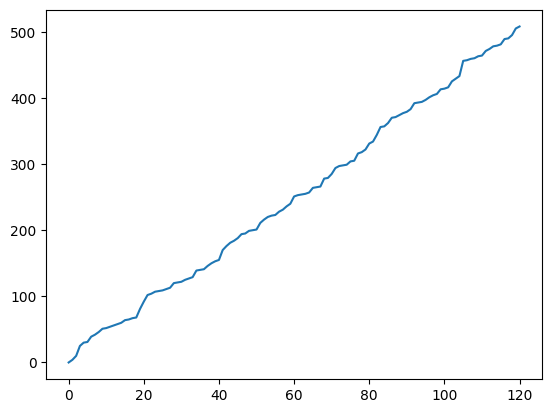

In [180]:
import matplotlib.pyplot as plt

mean_guess_latent_err_sum = guess_latent_err_sum/1000

filtered_list = []

for i in range(512):
    if abs(mean_guess_latent_err_sum[i]) < 0.2:
        filtered_list.append(i)

plt.plot(filtered_list)

In [89]:
filtered_list

[383, 505]

In [24]:
xT.size()

torch.Size([1, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


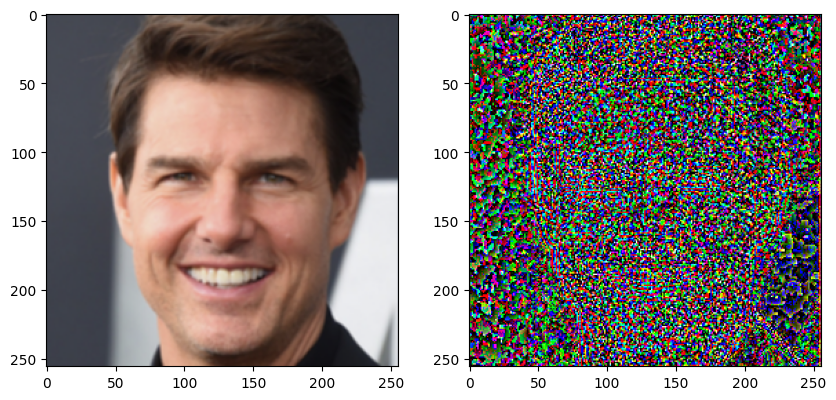

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())
plt.imsave("perturbed_imgs/1.png", ori[0].permute(1, 2, 0).cpu().numpy())

In [71]:
cls_id = CelebAttrDataset.cls_to_id['Wavy_Hair']
cond2 = cls_model.normalize(cond)
cond2 = cond2 + 0.3 * math.sqrt(512) * F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1)
cond2 = cls_model.denormalize(cond2)
cond2 = 0

In [198]:
perturbed = cond

In [105]:
original = cond

In [197]:
fake_guess = guess_cond_perturbed

In [113]:
original_guess = guess_cond_perturbed

In [50]:
err_ = guess_cond_perturbed - np.reshape(cond.cpu().numpy(), 512)

In [57]:
err_2 = guess_cond_perturbed - np.reshape(cond.cpu().numpy(), 512)

In [25]:
EPS = 6

cond_perturbed = dp_latent(np.reshape(cond.cpu().numpy(), 512), EPS)
guess_cond_perturbed = guess_original_latent(np.reshape(cond.cpu().numpy(), 512), filtered_list) 

for i in range(0):
    guess_cond_perturbed = guess_original_latent(guess_cond_perturbed, filtered_list)

print(np.linalg.norm(np.reshape(perturbed.cpu().numpy(), 512)-np.reshape(original.cpu().numpy(), 512)))
print(np.linalg.norm(fake_guess-np.reshape(original.cpu().numpy(), 512)))

# 2.1968162 1.png, 4.png
# 2.1523316

# print(np.linalg.norm(guess_cond_perturbed-np.reshape(cond.cpu().numpy(), 512)))
# print(np.linalg.norm(original_guess-np.reshape(original.cpu().numpy(), 512)))

# original - guess_using_original - 3.338664
# original - perturber - 2.1625426
# original - guess - 3.6130661324545494


# original - guess - 6.701610
# eps = 1 - guess - 7.03198
# original - eps = 1 - 2.10395

# original - guess - 6.70457
# eps = 1 - guess - 6.826711
# original - eps = 1 - 2.1625426

# for i in range(10):
#     perturbed_latent = dp_latent(X_train[i], EPS)
#     guess_latent = guess_original_latent(perturbed_latent)

#     perturbed_l2 = np.linalg.norm(perturbed_latent - X_test[i])
#     guessed_l2 = np.linalg.norm(guess_latent - X_test[i])

#     print("perturbed_l2 ", perturbed_l2, " guessed_l2 ", guessed_l2)

NameError: name 'filtered_list' is not defined

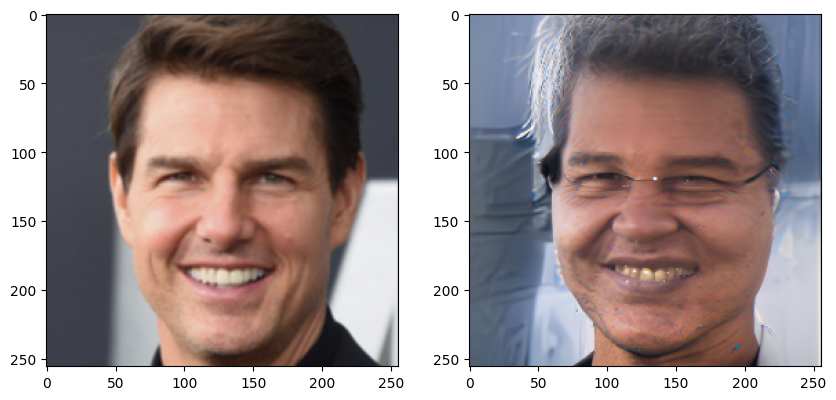

In [26]:


import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img = model.render(xT, (torch.from_numpy(np.reshape(cond_perturbed, (1,-1))).type(torch.float32).to(device)), T=100) #cond2, T=100)
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(img[0].permute(1, 2, 0).cpu())
plt.savefig('imgs_manipulated/compare.png')

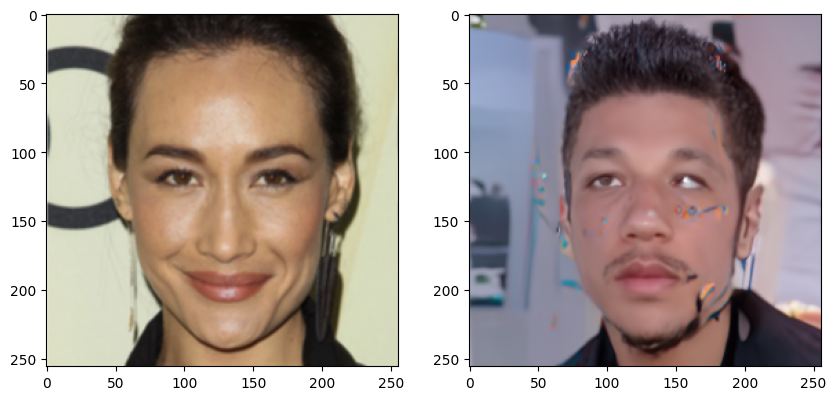

In [91]:


import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img = model.render(xT, (torch.from_numpy(np.reshape(perturbed_latent, (1,-1))).type(torch.float32).to(device)), T=100) #cond2, T=100)
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(img[0].permute(1, 2, 0).cpu())
plt.savefig('imgs_manipulated/compare.png')

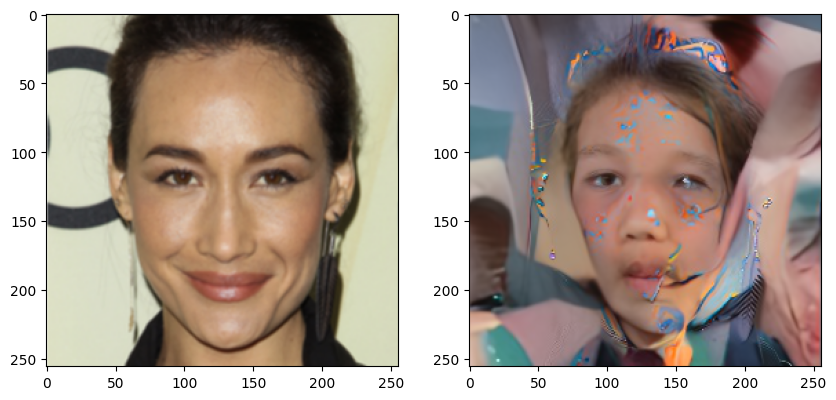

In [90]:


import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img = model.render(xT, (torch.from_numpy(np.reshape(guess_latent, (1,-1))).type(torch.float32).to(device)), T=100) #cond2, T=100)
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(img[0].permute(1, 2, 0).cpu())
plt.savefig('imgs_manipulated/compare.png')

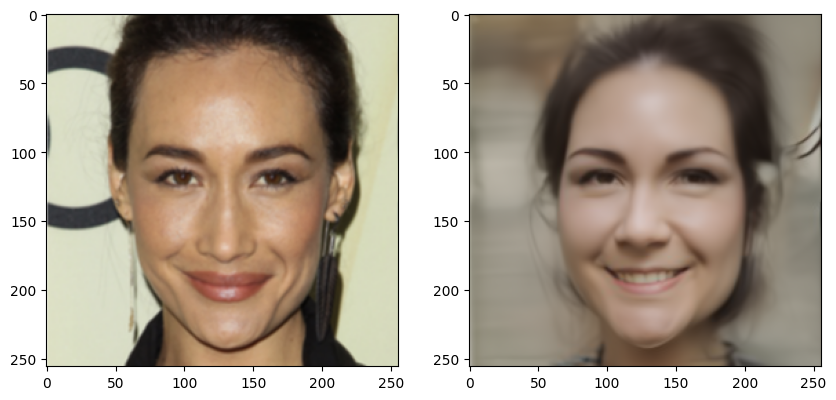

In [57]:


import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img = model.render(xT, original, T=100) #cond2, T=100)
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(img[0].permute(1, 2, 0).cpu())
plt.savefig('imgs_manipulated/compare.png')

In [118]:
# for i,model_ in enumerate(model_list):
#     with open(f'mlp_models/mlp_regression_model_32_16_200000_{i}.pkl', 'wb') as file:
#         pickle.dump(model_, file)

In [120]:
# loaded_model_list = []
# for i in range(LATENT_SIZE):
#     with open(f'mlp_models/mlp_regression_model_32_16_200000_{i}.pkl', 'rb') as file:
#         loaded_model_list.append(pickle.load(file))

In [ ]:
# # training dataset

# LATENT_SIZE = 512
# MAX_VARIANCE = 5

# # specify the module that needs to be
# # imported relative to the path of the
# # module
# # latent_load_module = importlib.util.spec_from_file_location("load_latent","/home/sjay9734/diff_encoder/face_privacy/face-privacy-diffae/utils/load_latent.py")
 
# # creates a new module based on spec
# # latent_load = importlib.util.module_from_spec(latent_load_module)
 
# # executes the module in its own namespace
# # when a module is imported or reloaded.
# # latent_load_module.loader.exec_module(latent_load)

# # X_train, y_train, X_test, y_test = latent_load.pre_process_celebA(TRAINING_AMOUNT = 0.9)

# def create_dataset(axis = 0):
#     i = 0
#     train_X_list = []
#     train_y_list = []

#     for i in range(LATENT_SIZE):
#         train_y_list.append([])

#     while i < (20000):
        
#         if np.random.randint(2, size=1) == 1:
#             train_X_list.append(X_train[i])
#             for 
#             train_y_list[axis].append(X_train[i][axis])
#             i += 1
#         else:
#             random_index = np.random.randint(len(X_train), size=1)
#             gaussian_noise = np.random.normal(loc=0.0, 
#                                             scale=np.random.randint(MAX_VARIANCE, size=1), size=LATENT_SIZE)
#             train_X_list.append(np.reshape(X_train[random_index] + gaussian_noise, (LATENT_SIZE)))
#             train_y_list[axis].append(X_train[random_index][axis])
            
#     augmented_train_X = np.array(train_X_list)
#     augmented_train_y = np.array(train_y_list)

#     return augmented_train_X, augmented_train_y